# Wage LSTM Model - Training (1997-2020), Training (2021-2023)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

import gdown
import time

In [2]:
# Load the dataset
url = 'https://drive.google.com/uc?id=1wjTiPLhi938Ro-jfjVHF0d_YPvsLaRc3'

# Download the file
output = 'data_wage.csv'
gdown.download(url, output, quiet=False)

# Check the file content
with open(output, 'r') as file:
    content = file.read()
    print("File content preview:")
    print(content[:500]) 

# Load the CSV file 
try:
    data = pd.read_csv(output, delimiter=',')  
    print(data.head())
except pd.errors.ParserError as e:
    print("Error parsing CSV file:", e)

Downloading...
From: https://drive.google.com/uc?id=1wjTiPLhi938Ro-jfjVHF0d_YPvsLaRc3
To: d:\OneDrive (Personal)\OneDrive\~ TMU 2023\CIND 820 - Big Data Analytics Project\06 - Initial Results & Code (10%)\data_wage.csv
100%|██████████| 80.1M/80.1M [00:02<00:00, 29.4MB/s]


File content preview:
ref_date,geo,wages,type_of_work,sex,age_group,value,occupation_classification,noc,sex_binary,age_group_numeric,geo_code,date_ordinal,year,month
1997-01-01,newfoundland and labrador,average hourly wage rate,full-time employees,males,25 to 54 years,18.7,legislative and senior management occupations,00,1,1,210,729025,1997,1
1997-02-01,newfoundland and labrador,average hourly wage rate,full-time employees,males,25 to 54 years,18.48,legislative and senior management occupations,00,1,1,210,729056,1997
     ref_date                        geo                     wages  \
0  1997-01-01  newfoundland and labrador  average hourly wage rate   
1  1997-02-01  newfoundland and labrador  average hourly wage rate   
2  1997-03-01  newfoundland and labrador  average hourly wage rate   
3  1997-04-01  newfoundland and labrador  average hourly wage rate   
4  1997-05-01  newfoundland and labrador  average hourly wage rate   

          type_of_work    sex       age_group  value  \


In [3]:
# Convert 'ref_date' to datetime
data['ref_date'] = pd.to_datetime(data['ref_date'], format='%Y-%m-%d')

# Label encode the 'occupation_classification' column
data['occupation_classification'] = data['occupation_classification'].astype(str)
label_encoder = LabelEncoder()
data['occupation_code'] = label_encoder.fit_transform(data['occupation_classification'])

In [4]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['value', 'date_ordinal', 'sex_binary', 'age_group_numeric', 'geo_code', 'occupation_code']])

# Function to create sequences for forecasting
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]  
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length
SEQ_LENGTH = 12

# Split the data into training and testing sets based on the date
train_data = data[data['ref_date'] < '2021-01-01']
test_data = data[data['ref_date'] >= '2021-01-01']

# Normalize training and testing data separately
scaled_train_data = scaler.fit_transform(train_data[['value', 'date_ordinal', 'year', 'month', 'sex_binary', 'age_group_numeric', 'geo_code', 'occupation_code']])
scaled_test_data = scaler.transform(test_data[['value', 'date_ordinal', 'year', 'month', 'sex_binary', 'age_group_numeric', 'geo_code', 'occupation_code']])

In [5]:
# Create sequences for training and testing
X_train, y_train = create_sequences(scaled_train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(scaled_test_data, SEQ_LENGTH)

# Define the LSTM model for forecasting
model = Sequential()
model.add(Input(shape=(SEQ_LENGTH, X_train.shape[2])))  
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

print(model.summary())

# Train the model
start = time.time()
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2)
end = time.time()

# Convert elapsed time to minutes and seconds
elapsed_time = end - start
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"\nTraining time: {minutes} minutes and {seconds} seconds")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,851 (46.29 KB)

 Trainable params: 11,851 (46.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/500
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 2/500
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 3/500
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 4/500
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 5/500
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 6/500
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 7/500
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 8/500
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 9/500
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 10/500
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 11/500
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.0024 - val_loss: 0.0028
Epo

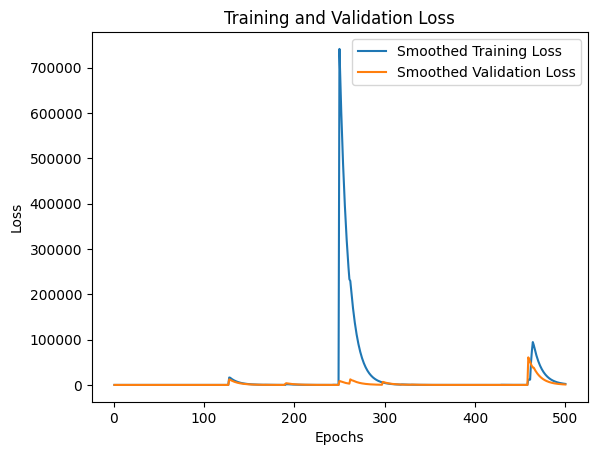

Best epoch based on validation loss: 56


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,851 (46.29 KB)

 Trainable params: 11,851 (46.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/56
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 2/56
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 3/56
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 4/56
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 5/56
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 6/56
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 7/56
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 8/56
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 9/56
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 10/56
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 11/56
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 12/56
94

In [6]:
# Define the smoothing function
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Retrieve loss and validation loss from history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Smooth the loss curves
smoothed_loss = smooth_curve(loss)
smoothed_val_loss = smooth_curve(val_loss)

# Plot smoothed training and validation loss
plt.plot(range(1, len(smoothed_loss) + 1), smoothed_loss, label='Smoothed Training Loss')
plt.plot(range(1, len(smoothed_val_loss) + 1), smoothed_val_loss, label='Smoothed Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Identify the epoch with the lowest validation loss
best_epoch = np.argmin(smoothed_val_loss) + 1
print(f"Best epoch based on validation loss: {best_epoch}")


# Refine the LSTM model 
model = Sequential()
model.add(Input(shape=(SEQ_LENGTH, X_train.shape[2]))) 
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))  
model.compile(optimizer='adam', loss='mse')

print(model.summary())

# Train the model
start = time.time()
history = model.fit(X_train, y_train, epochs=best_epoch, batch_size=32, validation_split=0.2)
end = time.time()

print(f"\nTraining time: {minutes} minutes and {seconds} seconds")

In [7]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and the actual values
predictions_inv = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_train_data.shape[1] - 1))), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_train_data.shape[1] - 1))), axis=1))[:, 0]

# Compare the first few predictions with the actual values
comparison = pd.DataFrame({'Actual': y_test_inv, 'Predicted': predictions_inv})
print(comparison.head())

1516/1516 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0225
Test Loss: 0.022555621340870857
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
   Actual  Predicted
0   48.51  21.124145
1   49.43  31.216181
2   49.78  33.773115
3   50.11  47.519050
4   52.02  41.261429


Downloading...
From: https://drive.google.com/uc?id=1wjTiPLhi938Ro-jfjVHF0d_YPvsLaRc3
To: d:\OneDrive (Personal)\OneDrive\~ TMU 2023\CIND 820 - Big Data Analytics Project\06 - Initial Results & Code (10%)\data_wage.csv
100%|██████████| 80.1M/80.1M [00:02<00:00, 38.7MB/s]


File content preview:
ref_date,geo,wages,type_of_work,sex,age_group,value,occupation_classification,noc,sex_binary,age_group_numeric,geo_code,date_ordinal,year,month
1997-01-01,newfoundland and labrador,average hourly wage rate,full-time employees,males,25 to 54 years,18.7,legislative and senior management occupations,00,1,1,210,729025,1997,1
1997-02-01,newfoundland and labrador,average hourly wage rate,full-time employees,males,25 to 54 years,18.48,legislative and senior management occupations,00,1,1,210,729056,1997
     ref_date                        geo                     wages  \
0  1997-01-01  newfoundland and labrador  average hourly wage rate   
1  1997-02-01  newfoundland and labrador  average hourly wage rate   
2  1997-03-01  newfoundland and labrador  average hourly wage rate   
3  1997-04-01  newfoundland and labrador  average hourly wage rate   
4  1997-05-01  newfoundland and labrador  average hourly wage rate   

          type_of_work    sex       age_group  value  \


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 50)             │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,451 (44.73 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 2/100
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 3/100
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 4/100
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 5/100
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 6/100
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 7/100
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 8/100
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 9/100
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 10/100
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 11/100
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0026 - val_loss: 0.0030
Epo

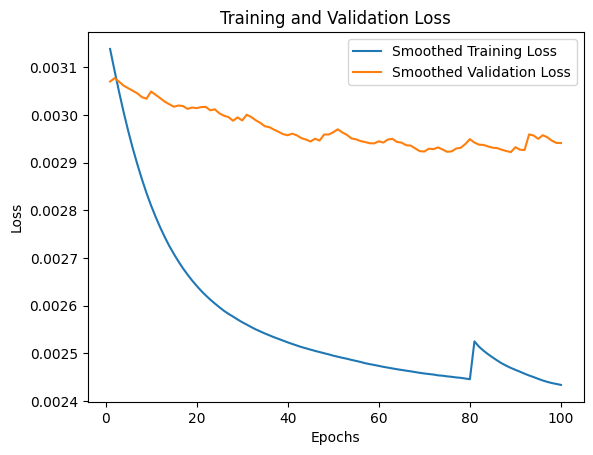

Best epoch based on validation loss: 89


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 50)             │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,451 (44.73 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/89
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0058 - val_loss: 0.0031
Epoch 2/89
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 3/89
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 4/89
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 5/89
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 6/89
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 7/89
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 8/89
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 9/89
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 10/89
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 11/89
9427/9427 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 12/89
94

In [8]:
# Wage LSTM Model - Training (1997-2020), Testing (2021-2023)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import gdown
import time

# Load the dataset
url = 'https://drive.google.com/uc?id=1wjTiPLhi938Ro-jfjVHF0d_YPvsLaRc3'

# Download the file
output = 'data_wage.csv'
gdown.download(url, output, quiet=False)

# Check the file content
with open(output, 'r') as file:
    content = file.read()
    print("File content preview:")
    print(content[:500]) 

# Load the CSV file 
try:
    data_wage = pd.read_csv(output, delimiter=',')  
    print(data_wage.head())
except pd.errors.ParserError as e:
    print("Error parsing CSV file:", e)

# Convert 'ref_date' to datetime
data_wage['ref_date'] = pd.to_datetime(data_wage['ref_date'], format='%Y-%m-%d')

# Change 'ref_date' format to '%Y-%m'
data_wage['ref_date'] = data_wage['ref_date'].dt.to_period('M').dt.to_timestamp()

# Label encode the 'occupation_classification' column
data_wage['occupation_classification'] = data_wage['occupation_classification'].astype(str)
label_encoder = LabelEncoder()
data_wage['occupation_code'] = label_encoder.fit_transform(data_wage['occupation_classification'])

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
features = ['value', 'date_ordinal', 'sex_binary', 'age_group_numeric', 'geo_code', 'occupation_code']
scaled_data = scaler.fit_transform(data_wage[features])

# Function to create sequences for forecasting
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]  
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length
SEQ_LENGTH = 12

# Split the data into training and testing sets based on the date
train_data = data_wage[data_wage['ref_date'] < '2021-01']
test_data = data_wage[data_wage['ref_date'] >= '2021-01']

# Normalize training and testing data separately
scaled_train_data = scaler.fit_transform(train_data[features])
scaled_test_data = scaler.transform(test_data[features])

# Create sequences for training and testing
X_train, y_train = create_sequences(scaled_train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(scaled_test_data, SEQ_LENGTH)

# Define cross-validation procedure
tscv = TimeSeriesSplit(n_splits=5)
cv_mse_scores = []

# Perform cross-validation
for train_index, val_index in tscv.split(X_train):
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    
    # Define the LSTM model for forecasting
    model = Sequential()
    model.add(Input(shape=(SEQ_LENGTH, X_train.shape[2])))  
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Train the model
    start = time.time()
    history = model.fit(X_train_cv, y_train_cv, epochs=100, batch_size=32, validation_data=(X_val_cv, y_val_cv), verbose=0)
    end = time.time()
    
    # Evaluate the model
    val_loss = model.evaluate(X_val_cv, y_val_cv, verbose=0)
    cv_mse_scores.append(val_loss)
    
    print(f"Validation Loss: {val_loss}, Training time: {end - start} seconds")

print('Cross-Validation Mean Squared Error:', np.mean(cv_mse_scores))

# Train the final model on the entire training set
model = Sequential()
model.add(Input(shape=(SEQ_LENGTH, X_train.shape[2])))  
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

print(model.summary())

start = time.time()
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)
end = time.time()

# Convert elapsed time to minutes and seconds
elapsed_time = end - start
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"\nTraining time: {minutes} minutes and {seconds} seconds")

# Retrieve loss and validation loss from history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the smoothing function
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Smooth the loss curves
smoothed_loss = smooth_curve(loss)
smoothed_val_loss = smooth_curve(val_loss)

# Plot smoothed training and validation loss
plt.plot(range(1, len(smoothed_loss) + 1), smoothed_loss, label='Smoothed Training Loss')
plt.plot(range(1, len(smoothed_val_loss) + 1), smoothed_val_loss, label='Smoothed Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Identify the epoch with the lowest validation loss
best_epoch = np.argmin(smoothed_val_loss) + 1
print(f"Best epoch based on validation loss: {best_epoch}")

# Refine the LSTM model 
model = Sequential()
model.add(Input(shape=(SEQ_LENGTH, X_train.shape[2]))) 
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))  
model.compile(optimizer='adam', loss='mse')

print(model.summary())

# Train the model
start = time.time()
history = model.fit(X_train, y_train, epochs=best_epoch, batch_size=32, validation_split=0.2)
end = time.time()

print(f"\nTraining time: {minutes} minutes and {seconds} seconds")

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and the actual values
predictions_inv = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_train_data.shape[1] - 1))), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_train_data.shape[1] - 1))), axis=1))[:, 0]

# Compare the first few predictions with the actual values
comparison = pd.DataFrame({'Actual': y_test_inv, 'Predicted': predictions_inv})
print(comparison.head())
